# Magic Models: Using Machine Learning to Afford Hobbies in Grad School

In this project, I am going to attempt to use machine learning to predict Magic: The Gathering card prices.

Magic: The Gathering is a trading card game that has been around for about 25 years.  Every year, new cards are released from Wizards of the Coast that players can buy, put in their decks, and play each other.  The competition ranges from casual to professional players flying halfway around the world to compete for thousands of dollars of prize money.  If you're interested in learning more, check out this awesome [video](https://www.youtube.com/watch?v=Plr81gaUIr0).  For me, it's mostly playing at my local game store with a big tournament sprinkled in here and there.  

One of the challenges is that Magic cards work like any other commodity, as the demand goes up or down given a certain supply, the price of cards can also fluctuate.  In cases like old powerful cards, there is a very small supply but a large demand causing them to sometimes be worth more than a used car.  Though I am not buying those kinds of cards, it still can be expensive and I am still in graduate school.  Thus, I wondered if I could use machine learning to help see when cards are going to spike or fall in price.  I know, I know you're thinking here's another person trying to predict something like the stock market.  I would, however, argue that the Magic economy is a bit more contained than the stock market in that there are less variables affecting prices.  Regardless of the outcome, this is still a great opportunity and use case to study time-series data, web scraping, and yes even neural networks.

## Introduction 

For this first part of the project, we are going to go after the low hanging fruit.  We will first web scrape some card prices, do exploratory data analysis, do some statistical tests to make sure we can use certain time-series models, and then build first a rolling mean model and then a neural network.  To break things this post will be dealing with the data engineering side of this project.  If you are more interested in the model building feel free to skip to [part 2](https://github.com/desdelgado/Magic_Models/blob/master/Single_Timestep_Univariable_%20Model_P2.ipynb). Finally, for proper citation, some of the code in this post was taken from Jason Brownlee at [Machine Learning Mastery](https://machinelearningmastery.com/) as well as [this video](https://www.youtube.com/watch?v=JntA9XaTebs) featuring Tamara Louie.

In [1]:
# First load in all the appropriate libraries.  Each library was added as I went along
# Data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
from bokeh.models import Legend
output_notebook()

import warnings

# Stats library
from statsmodels.tsa.stattools import adfuller

# Custom Package Written to Scape Webdata
from Web_Scrape import scrape_data

Loading BokehJS ...

For this first pass we are just going to look at one card and then go from there. One of the cards I have always wanted to buy but has been a bit pricey is a card called "Stoneforge Mystic."  After digging around a bit online, I concluded that we will need to web scrape the data.

In order to keep this report clean, I wrote up another notebook going over how I got the data from a website called [mtggoldfish](https://www.mtggoldfish.com/).  If you are interested, feel free to check it out [here](https://github.com/desdelgado/Magic_Models/blob/master/Webscrape.ipynb).  I then created a separate script that we can load in with our libraries.  Now we just have to input the card name and the card set and we'll get back a dataframe with the datetime as an index and the price on that day in the first column.

Finally, if you download the notebook, you can input and re-run this notebook with any card.  Though some of the written analysis will be off, my goal down the road is to make this as re-usable as possible. 

In [2]:
card_name = "Stoneforge Mystic"
card_set = "Worldwake"

# Custom script to get price data
data = scrape_data(card_name, card_set)

## Exploratory Data Analysis 

Let's do some quick exploratory  data analysis to get a feel for the data.

In [3]:
print(data.info())
print(data.head(15))
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3356 entries, 2010-11-02 to 2020-02-04
Data columns (total 1 columns):
Price    3356 non-null float64
dtypes: float64(1)
memory usage: 52.4 KB
None
            Price
Date             
2010-11-02  12.14
2010-11-03  12.14
2010-11-04  12.14
2010-11-05  12.13
2010-11-06  12.13
2010-11-07  12.12
2010-11-08  10.33
2010-11-09  10.33
2010-11-10  10.43
2010-11-11  10.53
2010-11-12  10.53
2010-11-13  10.53
2010-11-14  10.58
2010-11-15  10.58
2010-11-16  10.58
             Price
count  3356.000000
mean     21.823069
std      12.963345
min       5.840000
25%       9.830000
50%      19.990000
75%      28.792500
max      79.980000


From the `pd.info` call we can see that we don't have any missing values. Moreover, the price seems stable around $21 with a peak around $80.  

Let's now plot the data to see what the trends look like.

Side note: I have been having some fun with the [Bokeh](https://docs.bokeh.org/en/latest/) visualization library as of late and thus used it to plot our price vs time plot.  Such a library allows one to zoom in, scroll, etc using the tools on the right-hand side of the plot.  If one clones the notebook, feel free to explore the data a bit using those tools. 

In [4]:
p = figure(plot_width=800, plot_height = 500,
           x_axis_type='datetime')

p.line(data.index, data.Price)

p.xaxis.axis_label = 'Date'
p.xaxis.axis_label_text_font_size = "25px"
p.yaxis.axis_label = 'Price ($)'
p.yaxis.axis_label_text_font_size = "25px"

p.title.text = str(card_name) + " Price"
p.title.text_font_size = "30px"
p.title.align = "center"

show(p)

Cool, we can see various spikes over time along with periods of tanks.  For this first foray into a time-series case, we are just going to look at predicting the price one day ahead based on the historical data.  Later on, we'll look predicting more days ahead as well as adding other variables to this prediction.  


## Creating Target Variable

Before we go further, we should create our target variable for our model to both learn and test on.  In typical non time-series machine learning, we simply pick (or create) a column that we would like to predict based on different features.  In a time-series case, however, the historical data are the features and the next steps would be the target variable.  Thus, we can shift our price data one day forward using the `df.shift` call and then use that column as our target variable.  Let's write a function to quickly do that and print it out.

In [5]:
def shift_timeseries(data: pd.DataFrame, lag: int=1): 
    """
        Takes in a single column and shifts the data down by the
        number from 'lag.' Places zero in new spot.
        
        Input:
            data: Dataframe of a single column
            lag: Number of steps to shift data
        Returns:
            Dataframe with orignal data and shifted data
    """
    df = pd.DataFrame(data)
    
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.columns = ["Predict Price", "Price"]
    df.fillna(0, inplace=True)
    return df

In [6]:
shift_data = shift_timeseries(data);
shift_data.head(15)

,Predict Price,Price
Date,,
2010-11-02,0.00,12.14
2010-11-03,12.14,12.14
2010-11-04,12.14,12.14
2010-11-05,12.14,12.13
2010-11-06,12.13,12.13
2010-11-07,12.13,12.12
2010-11-08,12.12,10.33
2010-11-09,10.33,10.33
2010-11-10,10.33,10.43


As one can see, the first column is the same as the second column except there is a zero on the first day of the "Predict Price" column.  So now the first column number is the number that will precede the second columns number.

## Determining if Data is Stationary

Next, we need to determine if our data is stationary as a lot of time-series models make this assumption. Having 'stationary' data means that different statistical components such as the mean and variance remain constant throughout the dataset.  One thing to note is that this constant doesn't mean the series data doesn't change but rather the _way_ the data changes remains constant in time.

We will look at some mathematical tests later on, but I have always been a fan of visualizing the data to get a feel for statistical concepts. To do so, we'll use a rolling window (mean, std) on the data and then plot the result of that window.

In [7]:
def plot_stationary(dataframe: pd.DataFrame, window_length: int, column: str='Price'):
    """
        Intake a dataframe with the first column labeled price and the index a time series.  Plots the
        rolling mean and standard deviation
        
        Input:
            dataframe - dataframe with price as the first column and the 
                datetime as the index.
            window - Number of points one wants the rolling average or std to be. 
        Returns:
            None
    """
    roll_mean = dataframe[column].rolling( window = window_length).mean()
    roll_std = dataframe[column].rolling( window = window_length).std()
    
    # Plot rolling mean

    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(dataframe,
            color = 'blue',
            label = 'Orginal Data')
    ax.plot(roll_mean,
           color = 'red',
           label = 'Rolling Mean')
    ax.plot(roll_std,
           color = 'green',
           label = 'Rolling Std')
    
    ax.set_title('Rolling mean and Standard Deviation', fontsize=30)
    ax.set_xlabel('Date', fontsize=25)
    ax.tick_params(labelsize=20)
    ax.legend(loc = 'best')

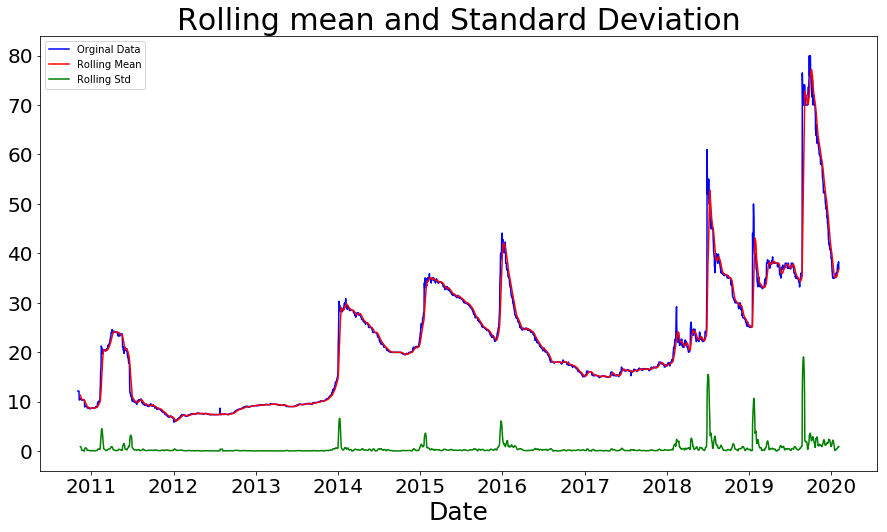

In [8]:
plot_stationary(data, 12)

Okay, let's break this down.  First, the mean appears to change over time so right away we know that we are not working with stationary data.  Second, for the most part, the standard deviation seems to be constant but has those spikes that cause it to not be completely stationary.  Finally, there appears to be no periodic pattern or seasonal trend to our data, so we don't have to worry about fixing that.  For more explanation about looking at whether a data set is stationary I'd highly recommend this [video](https://www.youtube.com/watch?v=oY-j2Wof51c).

Beyond visualization, we can also do statistical tests to see if our data is stationary. We can turn to the Augmented Dicky-Fuller (ADF) test which checks if there is a unit root in our process.  Simply put, if our process has a unit root, it is considered non-stationary.  In more plain terms, it tests if over time will our data return to some baseline by looking at the differences between data points.  This [video](https://www.youtube.com/watch?v=v70-kLB3BLM) was helpful in visualizing what a unit root of 1 or more means for time-series.  Moreover, this  ADF test returns two important statistics: the first being the classic p-value which we use to either accept or reject the null hypothesis that our data has a unit root, and the ADF statistic which tells us how strongly we can reject the null hypothesis at some confidence letter.  In short, were looking for a low p value and a negative ADF value so we can strongly reject the idea that our data is stationary.  Fortunately, python has the augmented Dicky-Fuller test as a function in the `statsmodels.tsa.stattools ` library.  Let's write a function that will do the Dicky-Fuller test and nicely print out the statistics we're interested in.

In [9]:
def ADF_print(data_val: np.ndarray):
    """
        Input 1-d array of the data and prints out the augmented Dicky-Fuller Test Metrics
        
        Inputs:
            data-val - 1-D array of data
        Returns:
            None 
    """
    result = adfuller(data_val)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [10]:
adf_test = data.iloc[:,0].values
ADF_print(adf_test)

ADF Statistic: -2.385516
p-value: 0.145866
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


We can see here that the ADF statistic is negative, however, the p-value is high.  Thus, we can't reject the null hypothesis and our data is non-stationary. (Double negative, I know).  This result agrees with what we saw in the earlier plots and quantifies those findings.  Again, we want to make sure our data is stationary because a lot of models have that assumption built into them.  Additionally, we might lose the time-dependent nature of our data.

## Data Transformation

From here, we can employ some transformations to make the data stationary and then test if these methods using the Augmented Dicky-Fuller test.  In this way, we are representing the data in a different form that could be stationary.  One of the easier first things we can try is to look at the differences between the numbers.  Let's write a function that will find the difference between a value and the one previously.

In [11]:
def difference(dataset: pd.Series, interval: int=1):
    """
        Intakes a series and returns the difference between each number and the value
        that is the interval number behind
        
        Inputs:
            dataset - data to find difference from point to pont
            interval - number of points backwards to find the difference between
        Returns:
            A dataframe series of the differences
    """
    diff=list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

After we run this transformation, let's also make a new dataframe with the difference as a column and the datetime index from our original dataframe so we can plot it. Note we'll have to take off the first datetime index since the difference function doesn't include it.

In [12]:
diff_data = pd.Series(data.Price)
diff_data = pd.DataFrame(difference(diff_data), columns = ['Price'])

# Convert the index to an array so we can index through it 
index_temp = np.array(data.index)
# Set the index with ignoring the first since there is no difference
diff_data = diff_data.set_index(index_temp[1:])

diff_data.columns = ["Price Difference"]
print(diff_data.head(10))

            Price Difference
2010-11-03              0.00
2010-11-04              0.00
2010-11-05             -0.01
2010-11-06              0.00
2010-11-07             -0.01
2010-11-08             -1.79
2010-11-09              0.00
2010-11-10              0.10
2010-11-11              0.10
2010-11-12              0.00


Cool, let's now plot the rolling mean and std again to get a visual and also do the Augmented Dicky Fuller test.

ADF Statistic: -16.596021
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


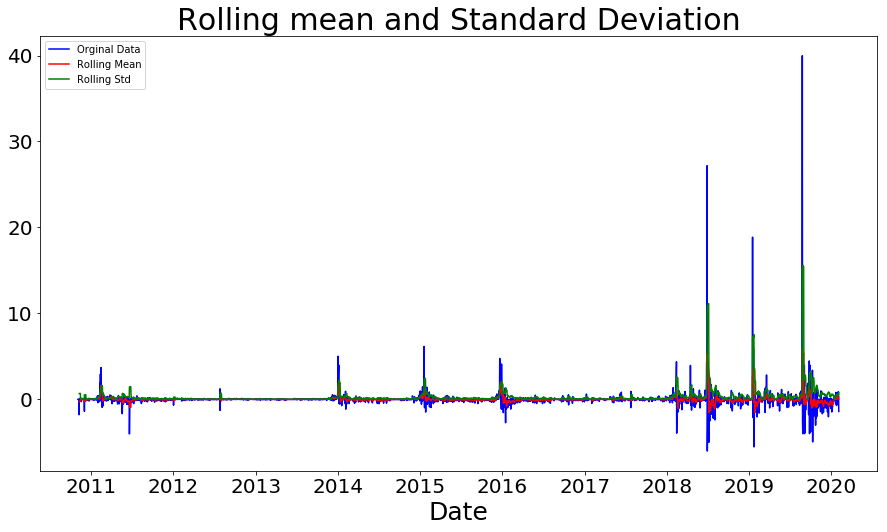

In [13]:
plot_stationary(diff_data, 7, column="Price Difference")
ADF_print(diff_data["Price Difference"])

Awesome! By using a simple differencing, we have transformed our data into being stationary and now can use different models.  First, for the most part we can see graphically the mean and standard deviation remains constant.  Though there are a few shocks, this data still returns to a constant value.  Second, we get an ADF statistic of -16 or so (remember the more negative the better) and a p value that is far less than the standard 0.05.  Thus, we can with confidence strongly reject the null hypothesis that our data is non-stationary.

Now let's now convert this difference data into something we can use in a prediction model by using our `shift_timeseries` function we wrote previously.

In [14]:
model_data = shift_timeseries(diff_data,1)
print(model_data.head())

            Predict Price  Price
2010-11-03           0.00   0.00
2010-11-04           0.00   0.00
2010-11-05           0.00  -0.01
2010-11-06          -0.01   0.00
2010-11-07           0.00  -0.01


Finally, we'll save the data to a csv file that we can acess when we start applying different models.

In [15]:
# Save data for later use
CSV_name = card_name.replace(" ", "_")
model_data.to_csv("Data/" + str(CSV_name)+ "_transform_data.csv")

## Conclusion 

In summary, we have loaded in our data from [web-scraping](https://github.com/desdelgado/Magic_Models/blob/master/Webscrape.ipynb) script and then performed some exploratory data analysis on it.  From there, we created our target variable which was a bit different than usual because this is time-series data.  Instead of having a bunch of features and a target, we shifted our data by one day ahead and make the next number the target variable.  From there we explored both visually and statistically using the Augmented Dicky-Fuller if our data was stationary.  Remember that a lot of models for time-series analysis require our data be stationary or in other words statistics such as mean, and variance remain constant.  After finding we had some non-stationary data on our hands, we applied a simple differencing between the values in order to make the data stationary.  

In [part 2](https://github.com/desdelgado/Magic_Models/blob/master/Single_Timestep_Univariable_%20Model_P2.ipynb) of this post, we'll explore some different models to help predict Magic card prices and hopefully be able to more easily afford this hobby in graduate school.  